# Introduction to Machine Learning - Ma422
## Model notebook

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import os
import math as m
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
import datetime
from PIL import Image
from tqdm.notebook import tqdm #progressbar

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Dense, Activation, MaxPool2D, BatchNormalization, \
Dropout, LeakyReLU, Flatten, InputLayer, AveragePooling2D, ZeroPadding2D
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.backend import clear_session
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorboard import notebook
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError

In [ ]:
data = pd.read_csv("drive/MyDrive/Machine_Learning/Kaggle/data/training.zip", compression='zip')

In [ ]:
print(data.shape)
data.head()

(7049, 31)


,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


left_eyebrow_outer_end_y     4824
left_eyebrow_outer_end_x     4824
right_eyebrow_outer_end_y    4813
right_eyebrow_outer_end_x    4813
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
mouth_left_corner_y          4780
mouth_left_corner_x          4780
right_eyebrow_inner_end_x    4779
mouth_right_corner_x         4779
right_eyebrow_inner_end_y    4779
left_eyebrow_inner_end_y     4779
left_eyebrow_inner_end_x     4779
mouth_right_corner_y         4779
left_eye_inner_corner_y      4778
left_eye_inner_corner_x      4778
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_y      33
mouth_center_bottom_lip_x      33
right_eye_center_y             13
right_eye_center_x             13
left_eye_center_x              10
left_eye_center_y              10
nose_tip_y                      0
nose_tip_x    

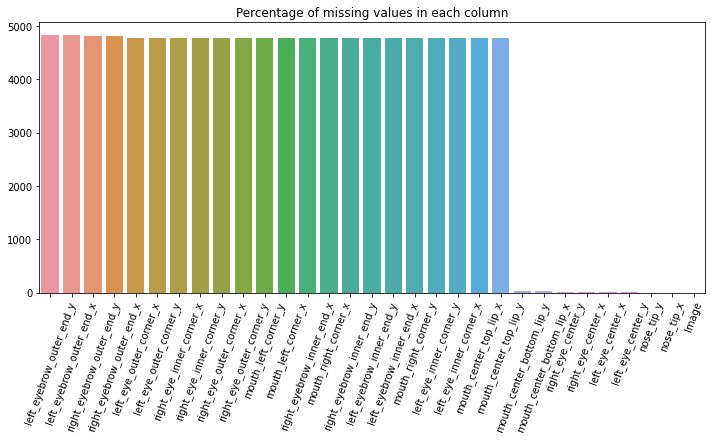

In [ ]:
# filter missing values, get the average number and sort each column by average
distr_missing_value = data.isnull().sum().sort_values(ascending=False) 
print(distr_missing_value)

plt.figure(figsize=(10,6))

sns.barplot(x=distr_missing_value.index, y=distr_missing_value.values)

plt.xticks(rotation=70)
plt.tight_layout()
plt.title("Percentage of missing values in each column")

plt.show()

In [ ]:
lm_names = ['left_eye_center','right_eye_center','left_eye_inner_corner','left_eye_outer_corner','right_eye_inner_corner',\
         'right_eye_outer_corner','left_eyebrow_inner_end','left_eyebrow_outer_end','right_eyebrow_inner_end',\
         'right_eyebrow_outer_end','nose_tip','mouth_left_corner','mouth_right_corner','mouth_center_top_lip',\
         'mouth_center_bottom_lip'] #landmarks names

# dict_names = dict()
# for name in lm_names:
#     if distr_missing_value[name+'_x'] > 0:
#         dict_names[name] = pd.DataFrame([data[name+'_x'], data[name+'_y']])
#         dict_names[name].dropna(inplace= True, axis=1)
# # full_ds = data.copy(deep=False)


In [ ]:
# dict_names['left_eyebrow_outer_end']

In [ ]:
# nrow = 3
# ncol = m.ceil(len(dict_names)/nrow)
# figsize = (3*ncol, 2.5*nrow)
# fig, axes = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=figsize)
# for name, ax in zip(dict_names.keys(), axes.flat):
#     ax.scatter(dict_names[name].iloc[0], dict_names[name].iloc[1])
#     ax.title.set_text(name)
# #     ax.invert_xaxis()
#     plt.ylim(max(plt.ylim()), min(plt.ylim()))
# #     ax.set_xticks([])
# #     ax.set_yticks([])
# # fig.colorbar(img, cax=fig.add_axes([0.92, 0.25, 0.01, .5]))   # Add a colorbar on the right
# plt.show()

In [ ]:
data.fillna(method='ffill', inplace=True)

In [ ]:
distr_missing_value = data.isnull().sum().sort_values(ascending=False) 
print(distr_missing_value)

left_eye_center_x            0
right_eyebrow_inner_end_x    0
mouth_center_bottom_lip_y    0
mouth_center_bottom_lip_x    0
mouth_center_top_lip_y       0
mouth_center_top_lip_x       0
mouth_right_corner_y         0
mouth_right_corner_x         0
mouth_left_corner_y          0
mouth_left_corner_x          0
nose_tip_y                   0
nose_tip_x                   0
right_eyebrow_outer_end_y    0
right_eyebrow_outer_end_x    0
right_eyebrow_inner_end_y    0
left_eyebrow_outer_end_y     0
left_eye_center_y            0
left_eyebrow_outer_end_x     0
left_eyebrow_inner_end_y     0
left_eyebrow_inner_end_x     0
right_eye_outer_corner_y     0
right_eye_outer_corner_x     0
right_eye_inner_corner_y     0
right_eye_inner_corner_x     0
left_eye_outer_corner_y      0
left_eye_outer_corner_x      0
left_eye_inner_corner_y      0
left_eye_inner_corner_x      0
right_eye_center_y           0
right_eye_center_x           0
Image                        0
dtype: int64


In [ ]:
%%time
X = np.array(list(map(lambda x: np.fromstring(x, dtype=int, sep=' ').reshape((96,96)), data['Image'])))
y = data[data.columns[:-1]]

CPU times: user 3 s, sys: 409 ms, total: 3.41 s
Wall time: 5.35 s


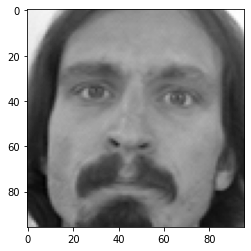

In [ ]:
plt.imshow(X[0], cmap='gray')
plt.show()

In [ ]:
print(X.shape)
print(y.shape)

(7049, 96, 96)
(7049, 30)


In [ ]:
col_x = y.columns[y.columns.str.endswith('x')]
col_y = y.columns[y.columns.str.endswith('y')]
y.loc[:,col_x] = y.loc[:,col_x].apply(lambda x: (x-48)/48)
y.loc[:,col_y] = y.loc[:,col_y].apply(lambda x: (x-48)/-48)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [ ]:
y

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,0.375699,0.187453,-0.370271,0.241215,0.241293,0.174012,0.523549,0.167292,-0.242571,0.221054,...,-0.074571,-0.188892,0.274902,-0.666045,-0.403865,-0.612271,-0.097654,-0.519489,-0.101444,-0.760120
1,0.340270,0.271457,-0.376057,0.303152,0.226170,0.265118,0.473390,0.246101,-0.249277,0.284135,...,0.004298,-0.159603,0.175447,-0.590667,-0.268284,-0.584326,-0.027404,-0.463887,-0.052752,-0.780837
2,0.355355,0.272716,-0.356171,0.272716,0.237750,0.243313,0.478842,0.243313,-0.215039,0.243313,...,-0.009224,-0.115395,0.267145,-0.521132,-0.297368,-0.515250,-0.015105,-0.462329,-0.015105,-0.638737
3,0.358870,0.223713,-0.332852,0.223713,0.250070,0.184850,0.506557,0.200397,-0.216278,0.192623,...,0.080939,-0.128470,0.366643,-0.514661,-0.224052,-0.545739,0.047983,-0.460243,0.074191,-0.630591
4,0.390110,0.174557,-0.328233,0.207458,0.220123,0.174557,0.510748,0.169074,-0.229534,0.185524,...,-0.097926,-0.351865,0.263988,-0.615067,-0.350172,-0.604110,-0.063276,-0.535571,-0.078601,-0.809816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7044,0.404220,0.336614,-0.380276,0.195147,0.234486,0.248643,0.540473,0.278653,-0.219197,0.179207,...,0.005541,-0.396439,0.512509,-0.497126,-0.286818,-0.611238,0.074989,-0.582575,0.050555,-0.660082
7045,0.377800,0.200719,-0.365029,0.167704,0.234486,0.248643,0.540473,0.278653,-0.219197,0.179207,...,-0.001868,-0.388042,0.512509,-0.497126,-0.286818,-0.611238,0.074989,-0.582575,0.047654,-0.624646
7046,0.389390,0.232391,-0.340283,0.173228,0.234486,0.248643,0.540473,0.278653,-0.219197,0.179207,...,0.030470,-0.406566,0.512509,-0.497126,-0.286818,-0.611238,0.074989,-0.582575,0.030470,-0.627440
7047,0.478439,0.169715,-0.363682,0.150576,0.234486,0.248643,0.540473,0.278653,-0.219197,0.179207,...,0.057379,-0.390104,0.512509,-0.497126,-0.286818,-0.611238,0.074989,-0.582575,0.043025,-0.658051


In [ ]:
X = X/255
# y[:,0:30:2] = (y[:,0:30:2]-48)/48
# y[:,1:30:2] = (y[:,1:30:2]-48)/-48
# print(y[0])

In [ ]:
X_inv = np.copy(X[:,:,::-1])


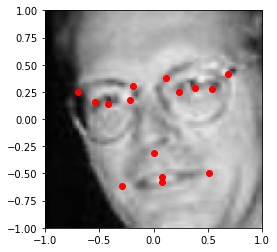

In [ ]:
idx = np.random.randint(0,X.shape[0])
plt.imshow(X[idx], cmap='gray', vmin=0, vmax=1, extent=[-1,1,-1,1])
for i in range(0,y.shape[1],2):
    plt.scatter(y.iloc[idx,i],y.iloc[idx,i+1],c='r')
plt.show()

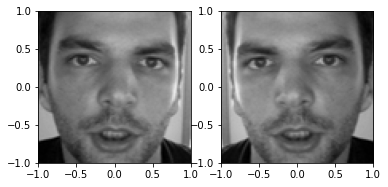

In [ ]:
idx = np.random.randint(0,X.shape[0])
fig, ax = plt.subplots(1,2)
ax[0].imshow(X[idx], cmap='gray', vmin=0, vmax=1, extent=[-1,1,-1,1])
ax[1].imshow(X_inv[idx], cmap='gray', vmin=0, vmax=1, extent=[-1,1,-1,1])
plt.show()

In [ ]:
y_inv = y.copy(deep=True)
y_inv.loc[:,col_x] = y_inv.loc[:,col_x].apply(lambda x: -1*x)

In [ ]:
col = list(y_inv.columns)
def swap_columns(L, col1, col2):
    new_L = L.copy()
    i_col1_x = L.index(col1+'_x')
    i_col1_y = L.index(col1+'_y')
    i_col2_x = L.index(col2+'_x')
    i_col2_y = L.index(col2+'_y')
    new_L[i_col1_x], new_L[i_col1_y], new_L[i_col2_x], new_L[i_col2_y] = L[i_col2_x], L[i_col2_y], L[i_col1_x], L[i_col1_y]
    return new_L
print("Before indexing :")
print(col[:5])
new_col = swap_columns(col, 'left_eye_center', 'right_eye_center')
print("After indexing :")
print(col[:5])

Before indexing :
['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y', 'left_eye_inner_corner_x']
After indexing :
['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y', 'left_eye_inner_corner_x']


In [ ]:
L_inv = [['left_eye_center', 'right_eye_center'],
         ['left_eye_inner_corner', 'right_eye_inner_corner'],
         ['left_eye_outer_corner', 'right_eye_outer_corner'],
         ['left_eyebrow_inner_end', 'right_eyebrow_inner_end'],
         ['left_eyebrow_outer_end', 'right_eyebrow_outer_end'],
         ['mouth_left_corner','mouth_right_corner']]

col_inv = list(y_inv.columns)

In [ ]:
for left_col, right_col in L_inv:
    col_inv = swap_columns(col_inv, left_col, right_col)

In [ ]:
y_inv = y_inv[col_inv]
y_inv = y_inv.set_axis(list(y.columns), axis=1)

In [ ]:
# print(y.head())
# print(y_inv.head())

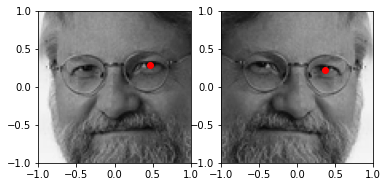

In [ ]:
idx = np.random.randint(0,X.shape[0])
fig, ax = plt.subplots(1,2)
ax[0].imshow(X[idx], cmap='gray', vmin=0, vmax=1, extent=[-1,1,-1,1])
ax[0].scatter(y.iloc[idx,0],y.iloc[idx,1],c='r')
ax[1].imshow(X_inv[idx], cmap='gray', vmin=0, vmax=1, extent=[-1,1,-1,1])
ax[1].scatter(y_inv.iloc[idx,0],y_inv.iloc[idx,1],c='r')
plt.show()

In [ ]:
# X_ds = np.concatenate([X, X_inv])
# y_ds = np.concatenate([y.to_numpy(), y_inv.to_numpy()])
X_ds = X
y_ds = y.to_numpy()

In [ ]:
print(X_ds.shape)
print(y_ds.shape)

(7049, 96, 96)
(7049, 30)


In [ ]:
X_trn, X_tst, y_trn, y_tst = train_test_split(X_ds, y_ds, train_size=0.9, random_state=0)

In [ ]:
print(X_trn.shape)
print(X_tst.shape)

(6344, 96, 96)
(705, 96, 96)


In [ ]:
clear_session()

model = Sequential([InputLayer(input_shape=(96, 96, 1)),
                    Conv2D(32, (3,3), padding="same", use_bias=False),
                    LeakyReLU(0.1),
                    BatchNormalization(),
                    Conv2D(32, (3,3), padding="same", use_bias=False),
                    LeakyReLU(0.1),
                    BatchNormalization(),
                    MaxPool2D((2,2)),
                    
                    Conv2D(64, (3,3), padding="same", use_bias=False),
                    LeakyReLU(0.1),
                    BatchNormalization(),
                    Conv2D(64, (3,3), padding="same", use_bias=False),
                    LeakyReLU(0.1),
                    BatchNormalization(),
                    MaxPool2D((2,2)),
                    
                    Conv2D(96, (3,3), padding="same", use_bias=False),
                    LeakyReLU(0.1),
                    BatchNormalization(),
                    Conv2D(96, (3,3), padding="same", use_bias=False),
                    LeakyReLU(0.1),
                    BatchNormalization(),
                    MaxPool2D((2,2)),
                    
                    Conv2D(128, (3,3), padding="same", use_bias=False),
                    LeakyReLU(0.1),
                    BatchNormalization(),
                    Conv2D(128, (3,3), padding="same", use_bias=False),
                    LeakyReLU(0.1),
                    BatchNormalization(),
                    MaxPool2D((2,2)),
                    
                    Conv2D(256, (3,3), padding="same", use_bias=False),
                    LeakyReLU(0.1),
                    BatchNormalization(),
                    Conv2D(256, (3,3), padding="same", use_bias=False),
                    LeakyReLU(0.1),
                    BatchNormalization(),
                    MaxPool2D((2,2)),
                    
                    Conv2D(512, (3,3), padding="same", use_bias=False),
                    LeakyReLU(0.1),
                    BatchNormalization(),
                    Conv2D(512, (3,3), padding="same", use_bias=False),
                    LeakyReLU(0.1),
                    BatchNormalization(),
#                     MaxPool2D((2,2)),
                    
                    Flatten(),
                    Dense(512, activation='relu'),
                    Dropout(0.1),
                    Dense(30)
                                  
], name="fkd_model")
model.summary()

Model: "fkd_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        288       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 96, 96, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 32)        9216      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 96, 96, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 96, 96, 32)       128       
 hNormalization)                                         

In [ ]:
%%time
earlystopping = EarlyStopping(monitor='val_mse', patience=40, restore_best_weights=True)
log_dir = "drive/MyDrive/Machine_Learning/Kaggle/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") # path for tensorboards logs
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1) #tensorboard callback function
 

model.compile(optimizer=Adam(),
              loss="mse",
              metrics=["mse", "mae"])

model.fit(
    X_trn,
    y_trn,
    epochs=200, 
    callbacks=[tensorboard, earlystopping],
    validation_data = (X_tst, y_tst)
   
)

save_model(model, "drive/MyDrive/Machine_Learning/Kaggle/"+model.name+".h5")

Epoch 1/200
199/199 [==============================] - 24s 106ms/step - loss: 0.0078 - mse: 0.0078 - mae: 0.0586 - val_loss: 0.0039 - val_mse: 0.0039 - val_mae: 0.0387
Epoch 2/200
199/199 [==============================] - 19s 96ms/step - loss: 0.0057 - mse: 0.0057 - mae: 0.0499 - val_loss: 0.0038 - val_mse: 0.0038 - val_mae: 0.0399
Epoch 3/200
199/199 [==============================] - 18s 92ms/step - loss: 0.0047 - mse: 0.0047 - mae: 0.0438 - val_loss: 0.0036 - val_mse: 0.0036 - val_mae: 0.0357
Epoch 4/200
199/199 [==============================] - 18s 92ms/step - loss: 0.0041 - mse: 0.0041 - mae: 0.0400 - val_loss: 0.0035 - val_mse: 0.0035 - val_mae: 0.0387
Epoch 5/200
199/199 [==============================] - 18s 93ms/step - loss: 0.0034 - mse: 0.0034 - mae: 0.0354 - val_loss: 0.0029 - val_mse: 0.0029 - val_mae: 0.0312
Epoch 6/200
199/199 [==============================] - 18s 91ms/step - loss: 0.0030 - mse: 0.0030 - mae: 0.0326 - val_loss: 0.0028 - val_mse: 0.0028 - val_mae: 0.02

In [ ]:
loaded_model = load_model("drive/MyDrive/Machine_Learning/Kaggle/fkd_model.h5")

In [ ]:
idx = np.random.randint(0,X_trn.shape[0])
pred_img = X_trn[idx].reshape((1,96,96))
pred = loaded_model.predict(np.expand_dims(pred_img, axis=3))
print(pred.shape)
plt.imshow(X_trn[idx], cmap='gray', vmin=0, vmax=1, extent=[-1,1,-1,1])
for i in range(0,pred.shape[1],2):
    plt.scatter(pred[0,i],pred[0,i+1],c='r')
plt.show()